In [5]:
import pandas as pd

df = pd.read_csv('dados_arduino.csv', encoding='ISO-8859-1')
df = df.head(1000)
display(df.head(5))

,Tempo_µs,Ciclo_CPU,Referencia_Motor,Vel_Real
0,456.0,424.0,0.0,0.0
1,972.0,512.0,0.0,0.0
2,1500.0,532.0,0.0,0.0
3,2064.0,556.0,0.0,0.0
4,2632.0,576.0,0.0,0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


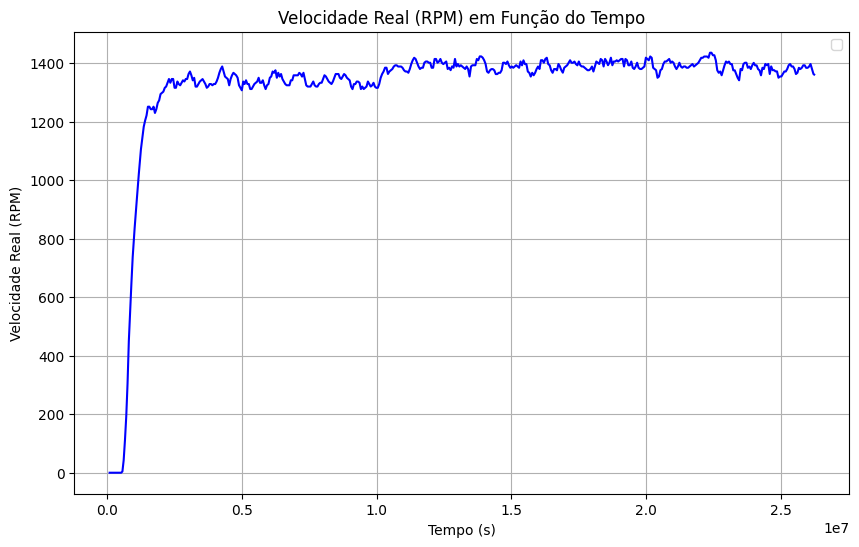

In [6]:
import matplotlib.pyplot as plt

# Calcular a média móvel de 10 valores
df['Vel_Real_Media'] = df['Vel_Real'].rolling(window=10).mean()

'''
# Criar o gráfico
plt.figure(figsize=(10, 6))  # Tamanho da figura
plt.plot(df['Tempo_µs'], df['Vel_Real'], label='Velocidade Real', color='b')  # Gráfico original
plt.plot(df['Tempo_µs'], df['Vel_Real_Media'], label='Média Móvel (20 valores)', color='r', linestyle='--')  # Gráfico da média móvel

# Adicionar título e rótulos aos eixos
plt.title('Velocidade Real (RPM) em Função do Tempo')
plt.xlabel('Tempo (s)')
plt.ylabel('Velocidade Real (RPM)')

# Mostrar a legenda
plt.legend()

# Mostrar o gráfico
plt.grid(True)  # Adicionar uma grade ao gráfico
plt.show()
'''

# Criar o gráfico
plt.figure(figsize=(10, 6))  # Tamanho da figura
plt.plot(df['Tempo_µs'], df['Vel_Real_Media'], color='b')
# Adicionar título e rótulos aos eixos
plt.title('Velocidade Real (RPM) em Função do Tempo')
plt.xlabel('Tempo (s)')
plt.ylabel('Velocidade Real (RPM)')
# Mostrar a legenda
plt.legend()
# Mostrar o gráfico
plt.grid(True)  # Adicionar uma grade ao gráfico
plt.show()



In [7]:
df['Vel_Real'] = df['Vel_Real_Media']
df = df[df['Vel_Real'].notna()]
df['Tempo_µs'] = df['Tempo_µs'] / 1e7 # Passar para segundos
df = df.reset_index(drop=True)
display(df.head()) 
print(df['Vel_Real'].max())

,Tempo_µs,Ciclo_CPU,Referencia_Motor,Vel_Real,Vel_Real_Media
0,0.008544,17684.0,0.0,0.0,0.0
1,0.010314,17680.0,0.0,0.0,0.0
2,0.012184,18716.0,0.0,0.0,0.0
3,0.014056,18724.0,0.0,0.0,0.0
4,0.015930,18720.0,0.0,0.0,0.0


1435.2


Deslocamento em t igual a 0.0536892
Regime permanente em: Tempo_µs                0.145514
Ciclo_CPU           26000.000000
Referencia_Motor     1500.000000
Vel_Real             1220.800000
Vel_Real_Media       1220.800000
Name: 61, dtype: float64
linha anterior None
valor anterior 0.0
Constante de tempo interpolada para 771.5455999999999 -> 0.042865078866472305
Media antes do degrau: 0.0
Media no regime permanente: 1174.5428571428572

Modelagem do Sistema de 1° Ordem
TIPO DA EQUAÇÃO:
velocidade_inicial + ganho_da_exponencial * (1 - e^(-(t - deslocamento_em_t) / constante_de_tempo))
VALORES DOS PARÂMETROS:
velocidade_inicial = 98.31666666666638
ganho_da_exponencial = 1122.4833333333336
deslocamento_em_t = 0.0536892
constante_de_tempo = 0.042865078866472305
Modelagem do Sistema de 1° Ordem: Resposta ao Degrau
Equação: ganho_do_degrau * (1 - ganho_da_exponencial * exp(-(t - deslocamento_em_t) / constante_de_tempo))
Parâmetros: ganho_do_degrau = 1220.8, ganho_da_exponencial = 1122.4833333

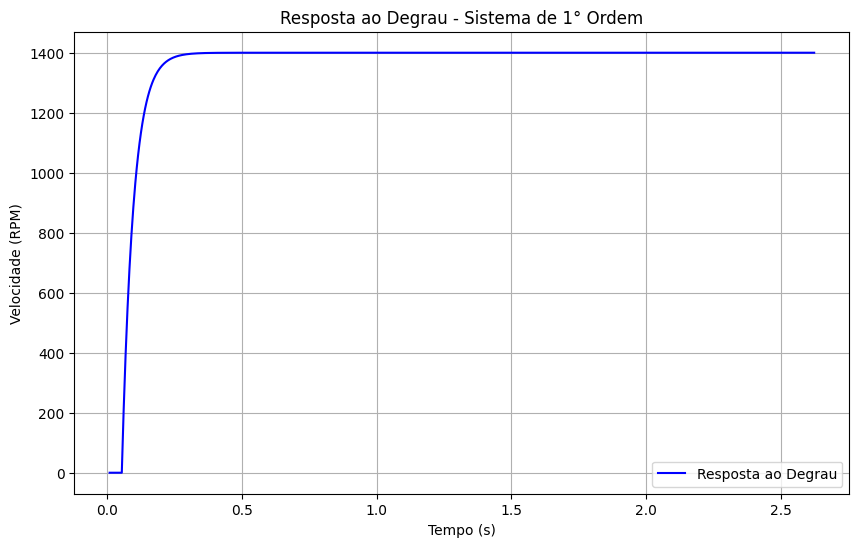

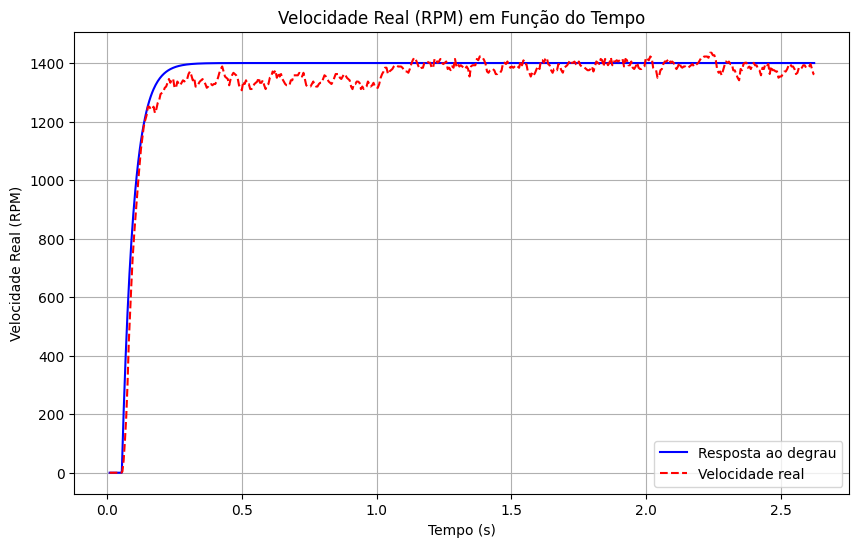

In [8]:
import pandas as pd
import math
import numpy as np

# Variáveis globais
deslocamento_em_t = None
linha_deslocamento_em_t = None

# Funções

def inicio_degrau(df):
    """Busca onde ocorre o degrau (aumento significativo na variável de interesse)."""
    for i in range(1, len(df)-2):
        derivada = (df['Vel_Real'][i+1] - df['Vel_Real'][i]) / (df['Tempo_µs'][i+1] - df['Tempo_µs'][i])
        if derivada > 0:
            return i + 1
    return -1  # Caso não encontre o degrau

def buscar_regime_permanente(df):
    """Busca o regime permanente no DataFrame, onde a variável 'Vel_Real' estabiliza."""
    for i in range(50, len(df)):
        valores = df['Vel_Real'][i-5:i]  # Usando os 5 dados anteriores
        media = valores.mean()  # Média
        amplitude = valores.max() - valores.min()  # Amplitude
        if amplitude < 0.05 * media:  # Critério de estabilidade 0.05
            return i
    return -1

def buscar_primeiro_tal_interpolado(df, valor_referencia, deslocamemto_em_t):
    """Busca o instante de tempo correspondente ao valor de 63,2% do regime permanente."""
    linha_anterior = None
    valor_anterior = df.iloc[0]['Vel_Real'] 
    print('linha anterior', linha_anterior)
    print('valor anterior', valor_anterior)
    for i, linha_atual in df.iloc[0:].iterrows(): 
        valor_atual = linha_atual['Vel_Real']
        if valor_anterior < valor_referencia <= valor_atual:
            x1 = df.iloc[i-1]['Tempo_µs']
            y1 = valor_anterior
            x2 = linha_atual['Tempo_µs']
            y2 = valor_atual
            constante_de_tempo = (x1 + (valor_referencia - y1) * (x2 - x1) / (y2 - y1)) - deslocamento_em_t
            return constante_de_tempo
        valor_anterior = valor_atual
        linha_anterior = linha_atual
    return -1

def curva_modelada(df, constante_de_tempo, ganho_da_exponencial, indice, titulo, deslocamento_em_t):
    """Gera a curva modelada com base nos parâmetros fornecidos e adiciona ao DataFrame."""
    ganho_do_degrau = df.iloc[indice]['Vel_Real']
    # Cria uma nova coluna no DataFrame para armazenar os valores modelados
    df[titulo] = [np.nan] * len(df)
    
    # Preenche os dados antes do degrau
    for i in range(linha_deslocamento_em_t):
        df.loc[i, titulo] = ganho_do_degrau * (1 - ganho_da_exponencial)

    # Preenche os dados após o degrau (resposta exponencial)
    for i in range(linha_deslocamento_em_t, len(df)):
        tempo = df.iloc[i]['Tempo_µs'] 
        if not pd.isna(ganho_da_exponencial) and not pd.isna(constante_de_tempo):
            df.loc[i, titulo] = ganho_do_degrau * (1 - ganho_da_exponencial * math.exp(-(tempo - deslocamento_em_t) / constante_de_tempo))
        else:
            print('Valores inválidos')
            
    print(f"Modelagem do Sistema de 1° Ordem: {titulo}")
    print(f"Equação: ganho_do_degrau * (1 - ganho_da_exponencial * exp(-(t - deslocamento_em_t) / constante_de_tempo))")
    print(f"Parâmetros: ganho_do_degrau = {ganho_do_degrau}, ganho_da_exponencial = {ganho_da_exponencial}, deslocamento_em_t = {deslocamento_em_t}, constante_de_tempo = {constante_de_tempo}")

# INÍCIO DO ALGORITMO

# Obtém onde a exponencial deve começar (onde ocorre o degrau)
linha_deslocamento_em_t = inicio_degrau(df)      
if linha_deslocamento_em_t != -1:
    deslocamento_em_t = df.iloc[linha_deslocamento_em_t]['Tempo_µs']
    print(f"Deslocamento em t igual a {deslocamento_em_t}")
else:
    print("Não foi possível determinar o deslocamento em t.")

# DETERMINAÇÃO DO REGIME PERMANENTE
indice_RP = buscar_regime_permanente(df)  # Índice da linha onde entra em regime permanente
if indice_RP != -1:
    print(f"Regime permanente em: {df.iloc[indice_RP]}")
else:
    print("Nenhum regime permanente encontrado.")

# SE O REGIME PERMANENTE FOR ENCONTRADO, CONTINUA A MODELAGEM
if indice_RP != -1:

    # DETERMINAÇÃO DO VALOR DE TAL
    valor_referencia = (df.iloc[indice_RP]['Vel_Real'] - df.iloc[0]['Vel_Real']) * 0.632 + df.iloc[0]['Vel_Real']

    # Método Interpolado
    if deslocamento_em_t:
        constante_de_tempo = buscar_primeiro_tal_interpolado(df, valor_referencia, deslocamento_em_t)
        if constante_de_tempo != -1:
            print(f"Constante de tempo interpolada para {valor_referencia} -> {constante_de_tempo}")
        else:
            print("Erro: não foi possível encontrar as duas linhas para interpolação.")

        # Calcula o ganho da exponencial
        media_antes = df['Vel_Real'][linha_deslocamento_em_t-7:linha_deslocamento_em_t].mean()
        media_depois = df['Vel_Real'][indice_RP-7:indice_RP].mean()
        print(f"Media antes do degrau: {media_antes}")
        print(f"Media no regime permanente: {media_depois}")
        ganho_da_exponencial = (df['Vel_Real'][indice_RP-12:indice_RP].mean() - df['Vel_Real'][linha_deslocamento_em_t-15:linha_deslocamento_em_t].mean())  # Média de 15 amostras antes e 15 amostras após o degrau
        
        if constante_de_tempo != -1 and deslocamento_em_t:
            print("")    
            print("Modelagem do Sistema de 1° Ordem")
            print("TIPO DA EQUAÇÃO:")
            print("velocidade_inicial + ganho_da_exponencial * (1 - e^(-(t - deslocamento_em_t) / constante_de_tempo))")
            print("VALORES DOS PARÂMETROS:")
            print(f"velocidade_inicial = {df.iloc[indice_RP]['Vel_Real'] - ganho_da_exponencial}") 
            print(f"ganho_da_exponencial = {ganho_da_exponencial}")
            print(f"deslocamento_em_t = {deslocamento_em_t}")
            print(f"constante_de_tempo = {constante_de_tempo}")

            # Chama a função de modelagem
            curva_modelada(df, constante_de_tempo, ganho_da_exponencial, indice_RP, "Resposta ao Degrau", deslocamento_em_t)

# Conversão de Tempo e Velocidade após o cálculo
#df['Tempo_Em_Segundos'] = df['Tempo_µs'] / 10**6  # Converter de microsegundos para segundos
#df['Velocidade_Em_Rad_s'] = df['Vel_Real'] * (2 * math.pi / 60)  # Converter de RPM para rad/s


# Definindo os valores mínimo e máximo da coluna original
resposta_min = df['Resposta ao Degrau'].min()  # Deve ser -926050.533333
resposta_max = df['Resposta ao Degrau'].max()  # Deve ser 0
novo_min = 0
novo_max = 1400
df['Resposta ao Degrau'] = (df['Resposta ao Degrau'] - resposta_min) / (resposta_max - resposta_min) * (novo_max - novo_min) + novo_min

# Plotando a resposta ao degrau (função de transferência aproximada)
plt.figure(figsize=(10, 6))
plt.plot(df['Tempo_µs'], df['Resposta ao Degrau'], label='Resposta ao Degrau', color='b')
plt.xlabel('Tempo (s)')
plt.ylabel('Velocidade (RPM)')
plt.title('Resposta ao Degrau - Sistema de 1° Ordem')
plt.grid(True)
plt.legend()
plt.show()

# Criar o gráfico
plt.figure(figsize=(10, 6))  # Tamanho da figura
pd.set_option('display.max_rows', None)
plt.plot(df['Tempo_µs'], df['Resposta ao Degrau'], label='Resposta ao degrau', color='b')  
plt.plot(df['Tempo_µs'], df['Vel_Real'], label='Velocidade real', color='r', linestyle='--')  
# Adicionar título e rótulos aos eixos
plt.title('Velocidade Real (RPM) em Função do Tempo')
plt.xlabel('Tempo (s)')
plt.ylabel('Velocidade Real (RPM)')
# Mostrar a legenda
plt.legend()
# Mostrar o gráfico
plt.grid(True)  # Adicionar uma grade ao gráfico
plt.show()


Função de Transferência da Malha Aberta:
G(s) = 127.8419 / (0.0429 * s + 1)


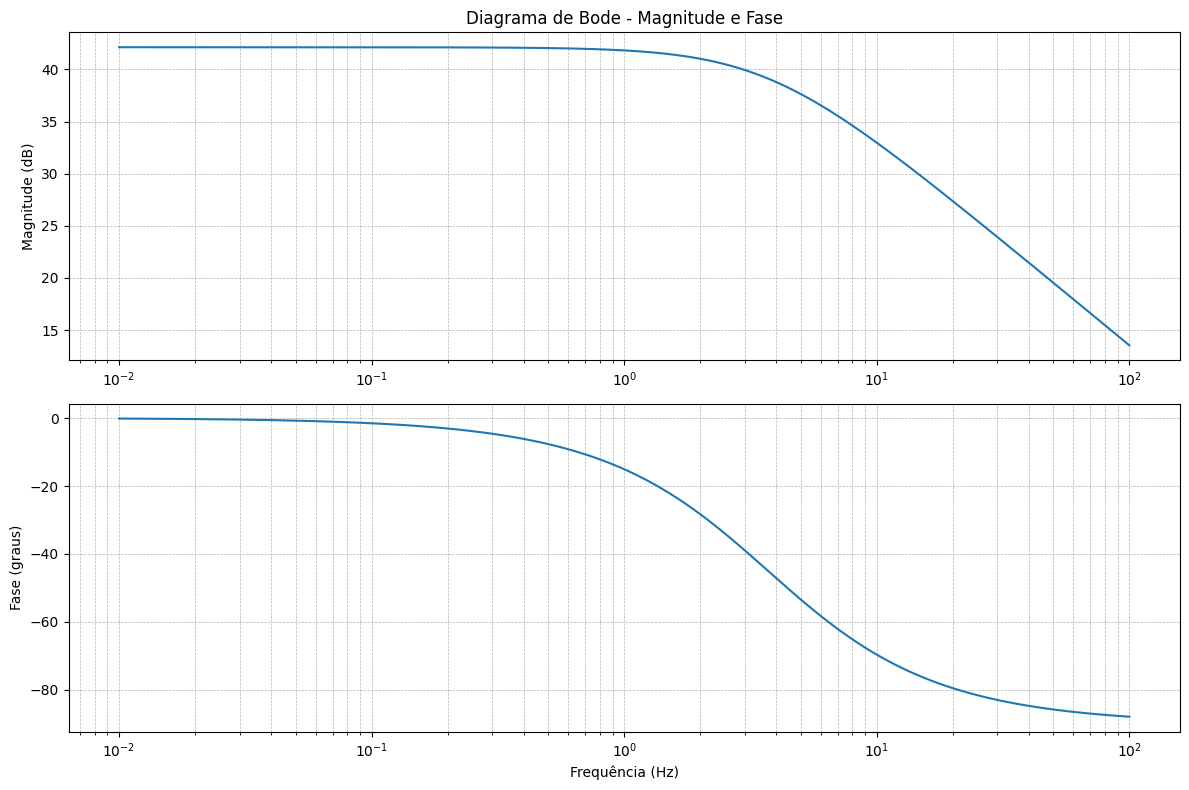

In [10]:
from scipy import signal

# Cálculo do ganho estático (K)
velocidade_inicial = df.iloc[linha_deslocamento_em_t - 1]['Vel_Real']
velocidade_final = df.iloc[indice_RP]['Vel_Real']
ganho_estatico_rpm = velocidade_final - velocidade_inicial
ganho_estatico = ganho_estatico_rpm * (2 * np.pi / 60)
# Impressão da Função de Transferência
if constante_de_tempo != -1:
    print("\nFunção de Transferência da Malha Aberta:")
    print(f"G(s) = {ganho_estatico:.4f} / ({constante_de_tempo:.4f} * s + 1)")
else:
    print("Não foi possível determinar a função de transferência.")

# Definindo o ganho estático (K) e a constante de tempo (tau)
K = ganho_estatico  
tau = constante_de_tempo  

# Criando a função de transferência no formato (numerador, denominador)
numerador = [K]
denominador = [tau, 1]

# Criando o sistema de 1ª ordem
sistema = signal.TransferFunction(numerador, denominador)

# Frequências para análise (logspace para cobrir várias ordens de magnitude)
frequencias = np.logspace(-2, 2, 500)  # De 0.01 Hz a 100 Hz

# Obtendo a resposta em frequência (magnitude e fase)
w, mag, fase = signal.bode(sistema, w=frequencias * 2 * np.pi)  # Convertendo Hz para rad/s

# Plotando o Diagrama de Bode
plt.figure(figsize=(12, 8))

# Magnitude
plt.subplot(2, 1, 1)
plt.semilogx(w / (2 * np.pi), mag)  # Convertendo de rad/s para Hz
plt.title('Diagrama de Bode - Magnitude e Fase')
plt.ylabel('Magnitude (dB)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Fase
plt.subplot(2, 1, 2)
plt.semilogx(w / (2 * np.pi), fase)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Fase (graus)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

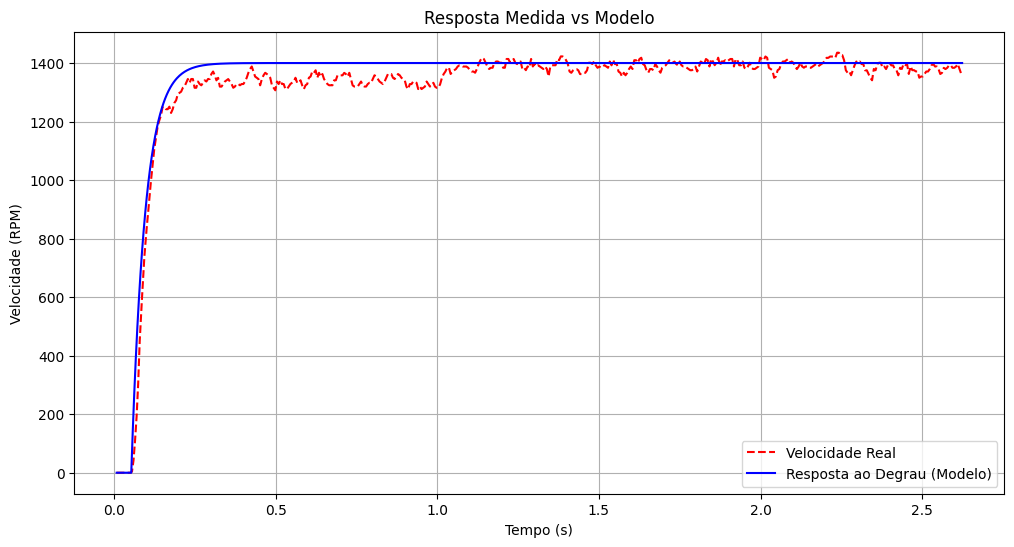

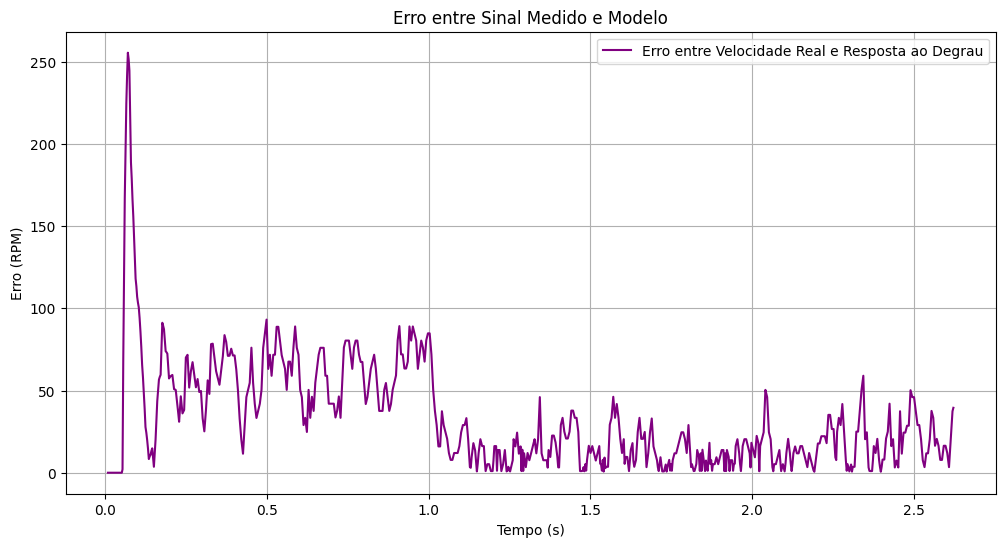

Erro Absoluto Médio (MAE): 33.62700988961146 RPM


In [11]:
# Cálculo do erro ponto a ponto (Erro Absoluto)
df['Erro'] = abs(df['Vel_Real'] - df['Resposta ao Degrau'])

import matplotlib.pyplot as plt

# Plotar a resposta medida e a modelada
plt.figure(figsize=(12, 6))
plt.plot(df['Tempo_µs'], df['Vel_Real'], label='Velocidade Real', color='red', linestyle='--')
plt.plot(df['Tempo_µs'], df['Resposta ao Degrau'], label='Resposta ao Degrau (Modelo)', color='blue')

plt.xlabel('Tempo (s)')
plt.ylabel('Velocidade (RPM)')
plt.title('Resposta Medida vs Modelo')
plt.legend()
plt.grid(True)
plt.show()

# Agora plotar o erro entre os dois sinais
plt.figure(figsize=(12, 6))
plt.plot(df['Tempo_µs'], df['Erro'], label='Erro entre Velocidade Real e Resposta ao Degrau', color='purple')

plt.xlabel('Tempo (s)')
plt.ylabel('Erro (RPM)')
plt.title('Erro entre Sinal Medido e Modelo')
plt.legend()
plt.grid(True)
plt.show()

# Erro Absoluto Médio (MAE)
mae = df['Erro'].mean()
# Exibir os resultados
print(f"Erro Absoluto Médio (MAE): {mae} RPM")